In [1]:
%reload_ext pytriqs.magic

In [2]:
from pytriqs.utility import mpi

Starting on 1 Nodes at : 2016-11-15 14:49:46.130017


In [6]:
%%triqs --only qmc
#include <triqs/mc_tools/mc_generic.hpp>
#include <triqs/utility/callbacks.hpp>

// --------------- configuration : a spin +1, -1 ---------------

struct configuration {
 int spin = -1;
};

// --------------- a move: flip the spin ---------------
struct flip {
 configuration* config;
 double beta_h;

 flip(configuration* config_, double beta, double h) : config(config_), beta_h(beta * h) {}

 double attempt() { return std::exp(-2 * config->spin * beta_h); }

 double accept() {
  config->spin *= -1;
  return 1.0;
 }

 void reject() {}
};

//  ----------------- a measurement: the magnetization ------------
class compute_m {
 configuration const * config;
 double& avg_magn;
 double Z = 0, M = 0;
 public:   

 compute_m(configuration* config_, double& avg_magn) : config(config_), avg_magn(avg_magn) {}

 void accumulate(double sign) {
  Z += sign;
  M += sign * config->spin;
 }

 void collect_results(triqs::mpi::communicator c) {
  avg_magn = M/Z;
 }
};

//  ----------------- main ------------

double qmc(double beta, double field) { 
  
 triqs::mpi::communicator world;
    
 // #parameters of the Monte Carlo
 int n_cycles = 5000000;
 int length_cycle = 10;
 int n_warmup_cycles = 10000;
 std::string random_name = "";
 int random_seed = 374982 + world.rank() * 273894;
 int verbosity = (world.rank() == 0 ? 2 : 0);

 // #Generic Monte Carlo
 triqs::mc_tools::mc_generic<double> SpinMC(random_name, random_seed, 1.0, verbosity);

 configuration config;
 double mag;

 // #add moves and measures
 SpinMC.add_move(flip(&config, beta, field), "flip move");
 SpinMC.add_measure(compute_m(&config, mag), "magnetization measure");

 // #Run and collect results
 SpinMC.warmup_and_accumulate(n_warmup_cycles, n_cycles, length_cycle, triqs::utility::clock_callback(600));
 SpinMC.collect_results(world);
 //std::cout << "Finished calculation for field = " << field << "." << std::endl;
 return mag;
}


----------------------------c++2py error ----------------------------
Welcome to the wrapper desc file generator of TRIQS, based on libclang !
Parsing the C++ file (may take a few seconds) ...
... done. 
Extracting ...
Traceback (most recent call last):
  File "/Users/parcolle/B/triqs/INSTALL_DIR/bin/c++2py.py", line 95, in <module>
    analyze_filter = analyze_filter)
  File "/Users/parcolle/triqs/BUILD/triqs/INSTALL_DIR/bin/clang_parser.py", line 396, in parse
    raise RuntimeError, s + "\n... Your code must compile before using clang-parser !"
RuntimeError: Clang reports the following errors in parsing
 file ./ext.cpp line 40 col 8
use of undeclared identifier 'sign2'
... Your code must compile before using clang-parser !



RuntimeError: Error


  $$\mathcal{H} = - h (n_\uparrow - n_\downarrow)$$

You want to compute the magnetization of this single spin. From statistical
mechanics it is clearly just



$$  m = \frac{1 - \exp(-2\beta h)}{1 + \exp(-2\beta h)}$$

In [4]:
import numpy as np
X = np.arange(0.1,2,0.2)
r = [qmc(2, h) for h in X]

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


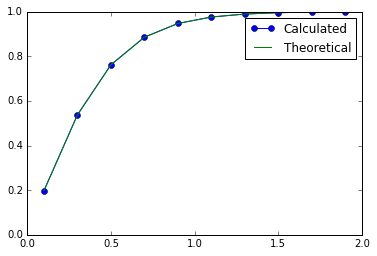

In [5]:
%matplotlib inline 
import matplotlib.pyplot as plt
r_theo = [(1- np.exp(-2 * 2*h))/ (1+ np.exp(-2 * 2*h)) for h in X]
plt.plot(X, r, '-o', label='Calculated')
plt.plot(X, r_theo, label='Theoretical')
plt.xlim(0,2)
plt.ylim(0,1)
plt.legend()